<a href="https://colab.research.google.com/github/KKawaguchi1219/Frog-Oscillator/blob/main/FrogOscillator_addSW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

方針，5/9時点：
1.  カエルは最近接の2匹の声しか聴かないようにする(Small World性)
2.  初期値依存性について検討する．
2.  カエルの個体数による秩序変数の違いを観察する．
3.  カエルの個体数比を1:1以外にも調査する．
4.  秩序変数の $c_{\rm{KL}}$ 依存性を調査する

余裕があれば検討：
1.  同一線上ではなく，厚みを持たせた空間をアトラクタ領域に設定する．
2.  空間の相互作用と位相の相互作用を分ける．
4.  2クラスター同期状態が破綻するのを判断する指標を作る


*   ダイナミクス

$
\begin{align}
    \frac{\mathrm{d} }{\mathrm{d}t}\theta_n &=\omega_n + \sum_{m\in \Lambda_n} -\frac{K_{mn}}{r_{mn}^2} \sin(\theta_m-\theta_n) \\
    \frac{\mathrm{d} }{\mathrm{d}t}\mathbb{r}_n &= \sum_{m\ne n} -\frac{K_{mn}}{r_{mn}^2} [1-\cos(\theta_m-\theta_n)\mathbb{e}_{mn}] + (L-|r_n|)\mathbb{e}_{n} \\
    \Lambda_n &: \text{n番目のカエルに最も近い2匹のカエルの添え字集合}\\
\end{align}
$

\
*   相互作用の強さ：

$
\begin{align}
    K_{mn} &= \frac{1}{c_{\mathrm{KL}}D_{\mathrm{KL}}(f_m,\ f_n)+1}, \quad D_{\mathrm{KL}}:\mathrm{Kullback–Leibler \ divergence}\\
    r_{mn} &= r_m-r_n, \\
    c_{\mathrm{KL}} &= \mathrm{const.}
\end{align}
$

frog1:シュレーゲルアオガエル \
frog2:二ホンアマガエル

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [ ]:
def Γ_mn(r_m, r_n, θ_m, θ_n, K_mn=1):
    return -K_mn/(np.linalg.norm(r_m-r_n)**2)*np.sin(θ_m-θ_n)

In [ ]:
def F_mn(r_m, r_n, θ_m, θ_n, K_mn=1):
    r_mn = r_m-r_n
    e_mn = r_mn/np.linalg.norm(r_mn)
    return -K_mn/(np.linalg.norm(r_mn)**2)*(1-np.cos(θ_m-θ_n))*e_mn

In [ ]:
def G_n(r_n, L):
    e_n = r_n/np.linalg.norm(r_n)
    return (L-np.linalg.norm(r_n))*e_n

In [ ]:
def KLdiv_norm(µ1, µ2):
    return (µ1-µ2)**2/2

In [ ]:
def Kmn_calc(µ_m, µ_n, r_m, r_n, c=1, k=1, c_kl=1e-4):
    return k/(c_kl*KLdiv_norm(µ_m, µ_n)+c)

In [ ]:
def frog_oscillator_SW(t, state, N, L, omega, µ, c_kl, freqs):

    theta, x, y = state[:N], state[N:2*N], state[2*N:]
    r = np.stack([x, y], axis=1)

    dtheta = np.full(N, omega)
    dr = np.zeros((N, 2))
    dx = np.zeros(N)
    dy = np.zeros(N)

    for i in range(N):

        # リンクを作る自分以外の2匹を選択
        distances = np.linalg.norm(r - r[i], axis=1)
        distances[i] = np.inf
        neighbors = np.argpartition(distances, 2)[:2]

        # 鳴き声の位相のみネットワーク上の3匹のみで計算
        for j in neighbors:
            assert i!=j, "i must not be j."

            K_mn = Kmn_calc(freqs[i], freqs[j], r[i], r[j], c_kl=c_kl)
            # phase
            dtheta[i] += Γ_mn(r[j], r[i], theta[j], theta[i], K_mn=K_mn)

        # 座標の計算は全てのカエルに対して計算する
        for j in range(N):
            if i==j: continue

            K_mn = Kmn_calc(freqs[i], freqs[j], r[i], r[j], c_kl=c_kl)
            # location
            dr[i] += F_mn(r[j], r[i], theta[j], theta[i], K_mn=K_mn)

        dr[i] += G_n(r[i], L)

        dx[i] = dr[i, 0]
        dy[i] = dr[i, 1]

    return np.concatenate([dtheta, dx, dy])


In [ ]:
N = 12              # カエルの個体数
L = 20              # 円の半径
omega = 4*2*np.pi   # 自然周波数

µ = np.array([2e3, 3.5e3])                                          # 鳴き声の周波数(正規分布)の平均
freqs = np.array([µ[0] if i < N // 2 else µ[1] for i in range(N)])  # 各カエルへの周波数の割り当て
c_kl = 1e-4                                                         # 相互作用の強さ

np.random.seed(0)
# カエルの初期配置
x = np.random.uniform(-L+5, L+5, N)
y = np.random.uniform(-L+5, L+5, N)

# 初期位相（ランダム設定）
theta1_init = np.random.normal(np.pi, 0.5, N//2)
theta2_init = np.random.normal(np.pi, 0.5, N//2)

# 初期状態まとめ
state_init = np.concatenate([theta1_init, theta2_init, x, y])

t_max=50000
dt=1
t_span = (0, t_max)  # 時間範囲
t_eval = np.arange(t_span[0], t_span[1], dt)  # 出力時間

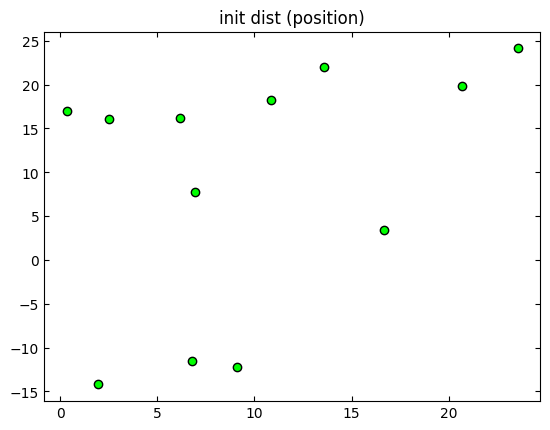

In [ ]:
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_title('init dist (position)')

r=np.stack([x, y], axis=1)
ax.scatter(r[:, 0], r[:, 1], c='lime', ec='k')
plt.show()

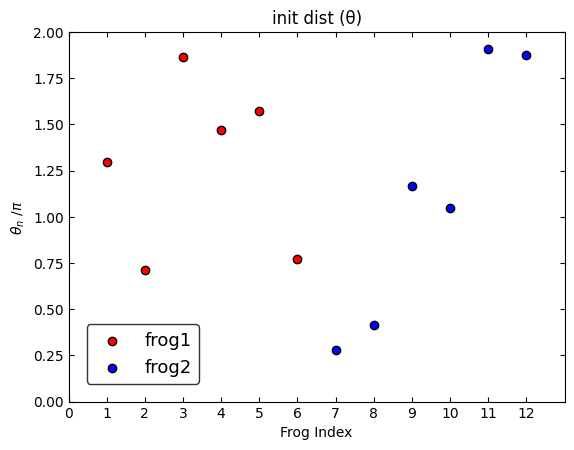

In [ ]:
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlim(0, N+1)
ax.set_ylim(0, 2)
ax.set_xlabel("Frog Index")
ax.set_ylabel(r'$\theta_n\ /\pi$')
ax.set_xticks(np.arange(N+1))
ax.set_title('init dist (θ)')

ax.scatter(np.arange(N//2)+1, (theta1_init % 2*np.pi)/np.pi, c='r', ec='k', label='frog1')
ax.scatter(np.arange(N//2, N)+1, (theta2_init % 2*np.pi)/np.pi, c='b', ec='k', label='frog2')
ax.legend(edgecolor='k', fontsize=13, borderaxespad=1)
plt.show()

In [ ]:
solution = solve_ivp(
    fun=frog_oscillator_SW,
    args=(N, L, omega, µ, c_kl, freqs),
    t_span=t_span,
    y0=state_init,
    t_eval=t_eval,
    method='RK45'
)

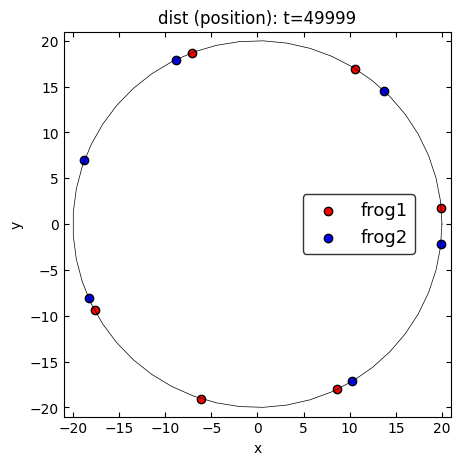

In [ ]:
time=int(len(solution.t)-1)

anystep_data = solution.y[:, time]
x_anystep = anystep_data[N:2*N]
y_anystep = anystep_data[2*N:]

fig, ax=plt.subplots(figsize=(5, 5))
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlim(-L-1, L+1)
ax.set_ylim(-L-1, L+1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"dist (position): t={time}")

ax.plot(L*np.cos(np.linspace(0, 2*np.pi)), L*np.sin(np.linspace(0, 2*np.pi)), lw=0.5, c='k')

ax.scatter(x_anystep[:N//2], y_anystep[:N//2], c='r', ec='k', label='frog1')
ax.scatter(x_anystep[N//2:N], y_anystep[N//2:N], c='b', ec='k', label='frog2')
ax.legend(loc='center right', edgecolor='k', fontsize=13, borderaxespad=2)

plt.show()

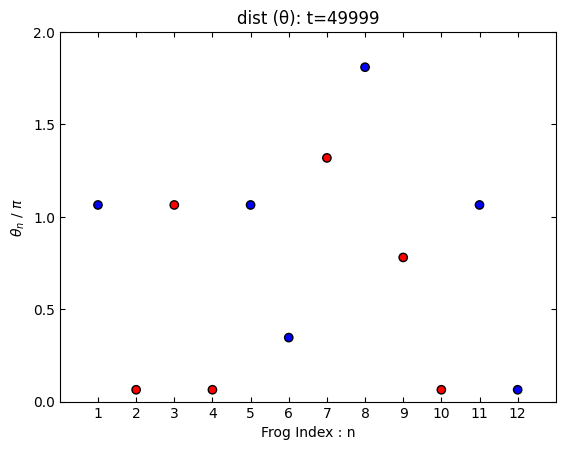

In [ ]:
fig, ax = plt.subplots()

n=np.arange(N)+1

ax.set_ylim(0, 2)
ax.set_xlim(0, N+1)
ax.set_xticks(n)
ax.set_yticks(np.arange(0, 2.1, 0.5))
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlabel("Frog Index : n")
ax.set_ylabel(r"$\theta_n \ /\ \pi$")
ax.set_title(f"dist (θ): t={time}")

# 任意の時刻での位相データ
anystep_data = solution.y[:, time]
θ_anystep = anystep_data[:N]

# 空間的な角度を元に，位相をソート
angle_equ_frog = np.atan2(y_anystep, x_anystep)
sort_indices = np.argsort(angle_equ_frog)
θ_anystep_sorted = θ_anystep[sort_indices]

# 色分け
colors = np.array(['red' if i < N // 2 else 'blue' for i in range(N)])
color_sorted = colors[sort_indices]

ax.scatter(n, (θ_anystep_sorted % (2*np.pi))/np.pi, c=color_sorted, ec='k')

plt.show()

In [ ]:
(θ_anystep_sorted % (2*np.pi))/np.pi

array([1.0640196 , 0.0640196 , 1.0640196 , 0.0640196 , 1.0640196 ,
       0.34623321, 1.31859152, 1.80944585, 0.77998211, 0.0640196 ,
       1.0640196 , 0.0640196 ])

order parameter

In [ ]:
# 周波数が同じ種間のR_{cluster}とR_{in}を計算

R_cluster_frog1, R_cluster_frog2, R_in_frog1, R_in_frog2 = [], [], [], []

for i_step_data in solution.y.T:
    θ_equ = i_step_data[:N]
    frog1_θ, frog2_θ = θ_equ[:N//2], θ_equ[N//2:]

    R_cluster_frog1.append(np.abs(np.mean(np.exp(1j * 2 * frog1_θ))))
    R_cluster_frog2.append(np.abs(np.mean(np.exp(1j * 2 * frog2_θ))))
    R_in_frog1.append(np.abs(np.mean(np.exp(1j * frog1_θ))))
    R_in_frog2.append(np.abs(np.mean(np.exp(1j * frog2_θ))))

In [ ]:
# 全てのカエルのR_{cluster}とR_{in}を計算

R_cluster, R_in = [], []

for i_step_data in solution.y.T:
    θ_equ = i_step_data[:N]
    R_cluster.append(np.abs(np.mean(np.exp(1j * 2 * θ_equ))))
    R_in.append(np.abs(np.mean(np.exp(1j * θ_equ))))

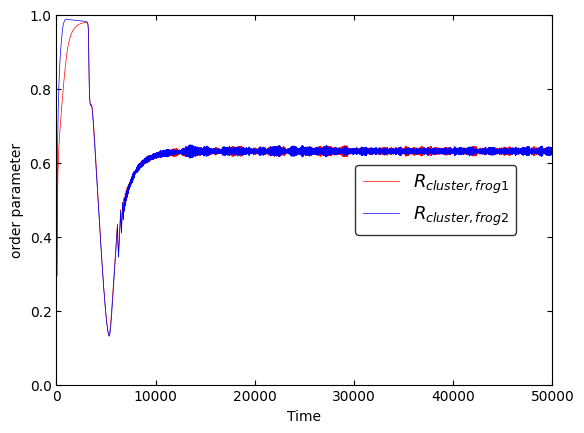

In [ ]:
fig, ax = plt.subplots()
n=np.arange(1, N+1)
ax.set_ylim(0, 1)
ax.set_xlim(0, t_max)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlabel("Time")
ax.set_ylabel('order parameter')

ax.plot(solution.t, R_cluster_frog1, c='r', lw=0.5, label=r'$R_{cluster, frog1}$')
ax.plot(solution.t, R_cluster_frog2, c='b', lw=0.5, label=r'$R_{cluster, frog2}$')

ax.legend(loc='center right', edgecolor='k', fontsize=13, borderaxespad=2)
plt.show()

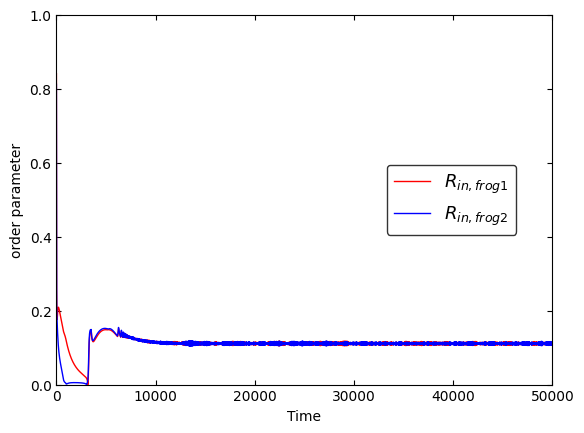

In [ ]:
fig, ax = plt.subplots()
n=np.arange(1, N+1)
ax.set_ylim(0, 1)
ax.set_xlim(0, t_max)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlabel("Time")
ax.set_ylabel('order parameter')

ax.plot(solution.t, R_in_frog1, c='r', lw=1, label=r'$R_{in, frog1}$')
ax.plot(solution.t, R_in_frog2, c='b', lw=1, label=r'$R_{in, frog2}$')

ax.legend(loc='center right', edgecolor='k', fontsize=13, borderaxespad=2)
plt.show()

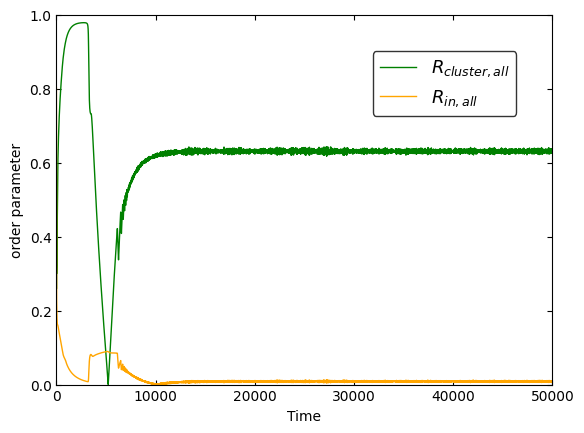

In [ ]:
fig, ax = plt.subplots()
n=np.arange(1, N+1)
ax.set_ylim(0, 1)
ax.set_xlim(0, t_max)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlabel("Time")
ax.set_ylabel('order parameter')

ax.plot(solution.t, R_cluster, c='g', lw=1, label=r'$R_{cluster, all}$')
ax.plot(solution.t, R_in, c='orange', lw=1, label=r'$R_{in, all}$')

ax.legend(loc='upper right', edgecolor='k', fontsize=13, borderaxespad=2)
plt.show()

**coupled test**

r=array([[ 2.48357077, -0.69132151],
       [ 3.23844269,  7.61514928],
       [-1.17076687, -1.17068478],
       [ 7.89606408,  3.83717365],
       [-2.34737193,  2.71280022],
       [-2.31708846, -2.32864877],
       [ 1.20981136, -9.56640122],
       [-8.62458916, -2.81143765],
       [-5.0641556 ,  1.57123666],
       [-4.54012038, -7.06151851]])
distances=array([ 3.68564414,  9.83015815,         inf, 10.3578989 ,  4.05781409,
        1.62939675,  8.72669509,  7.63226943,  4.76199633,  6.78634401])
点 2 に最も近い2点のインデックス: [5 0]


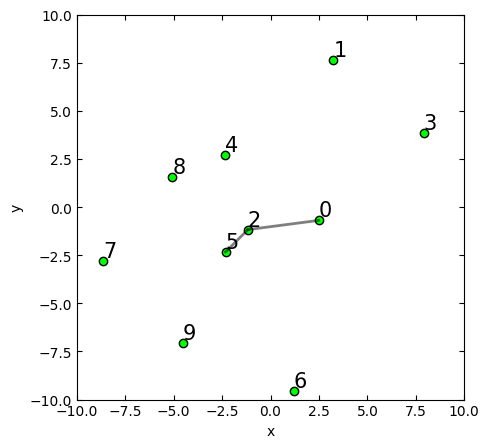

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
r = np.random.randn(10, 2) * 5

i = 2
# 1. 各点とのユークリッド距離をまとめて計算
distances = np.linalg.norm(r - r[i], axis=1)
# 2. 自分自身の距離だけ無限大にする
distances[i] = np.inf
# 3. 上位2点のインデックスを取得（argpartition の方が大規模データに有利）
neighbors = np.argpartition(distances, 2)[:2]
# （ソートされた順位まで正確に欲しい場合は argsort[:2] でも可）
# neighbors = np.argsort(distances)[:2]

print(f'{r=}')
print(f'{distances=}')
print(f"点 {i} に最も近い2点のインデックス: {neighbors}")

fig, ax = plt.subplots(figsize=(5, 5))
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(r[:, 0], r[:, 1], c='lime', ec='k')
for neighbor in neighbors:
    ax.plot([r[i, 0], r[neighbor, 0]], [r[i, 1], r[neighbor, 1]], lw=2, c='k', alpha=0.5)
ax.plot()
for iter, (x,y) in enumerate(r):
    ax.annotate(str(iter),(x,y), size=15, ha='left', va='bottom')

plt.show()

[]

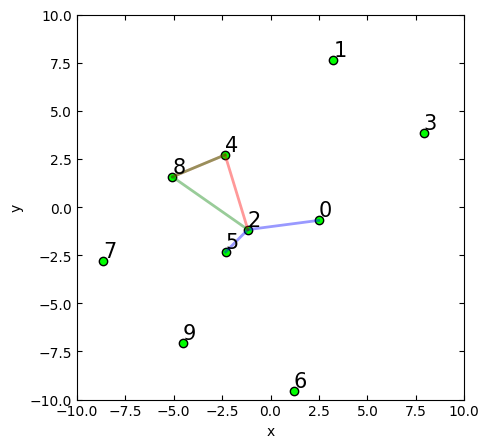

In [ ]:
np.random.seed(42)
r = np.random.randn(10, 2)*5

fig, ax = plt.subplots(figsize=(5, 5))
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(r[:, 0], r[:, 1], c='lime', ec='k')
for i,(x,y) in enumerate(r):
    ax.annotate(str(i),(x,y), size=15, ha='left', va='bottom')

frogs=[2, 4, 8]
color_lis=["b", "r", "g"]
for color, i in enumerate(frogs):

    # 最近傍の2点を探索
    distances = np.linalg.norm(r - r[i], axis=1)
    distances[i] = np.inf
    neighbors = np.argpartition(distances, 2)[:2]

    for k, neighbor in enumerate(neighbors):
        ax.plot([r[i, 0], r[neighbor, 0]], [r[i, 1], r[neighbor, 1]], color=color_lis[color], lw=2, alpha=0.4)

ax.plot()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
r = np.random.randn(10, 2)*5
print(r)

# 粒子番号iの粒子に最も近い2つの粒子をリストneighborに加える．
i=2
r_diff=[]
for j in range(len(r)):
    r_ij=np.linalg.norm(r[i]-r[j])
    r_diff.append(r_ij)

print(f'{len(r_diff)=}')
print(f'{r_diff=}')
neighbors = np.argsort(r_diff)[:3]
neighbors = neighbors[neighbors!=i]
print(f'{neighbors=}')

[[ 2.48357077 -0.69132151]
 [ 3.23844269  7.61514928]
 [-1.17076687 -1.17068478]
 [ 7.89606408  3.83717365]
 [-2.34737193  2.71280022]
 [-2.31708846 -2.32864877]
 [ 1.20981136 -9.56640122]
 [-8.62458916 -2.81143765]
 [-5.0641556   1.57123666]
 [-4.54012038 -7.06151851]]
len(r_diff)=10
r_diff=[np.float64(3.68564414052268), np.float64(9.830158148749515), np.float64(0.0), np.float64(10.357898896824207), np.float64(4.057814094306036), np.float64(1.6293967518351944), np.float64(8.726695092213387), np.float64(7.632269431015324), np.float64(4.761996326461052), np.float64(6.7863440064794585)]
neighbors=array([5, 0])


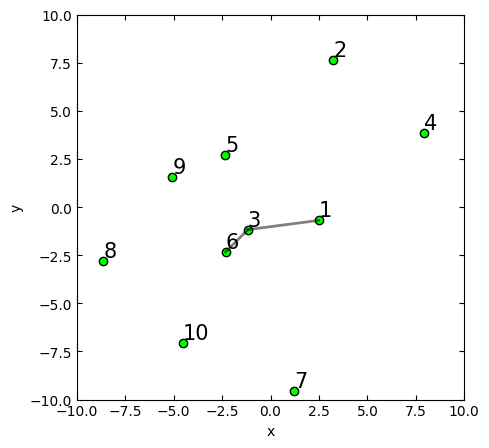

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(r[:, 0], r[:, 1], c='lime', ec='k')
for neighbor in neighbors:
    ax.plot([r[i, 0], r[neighbor, 0]], [r[i, 1], r[neighbor, 1]], lw=2, c='k', alpha=0.5)
ax.plot()
for iter, (x,y) in enumerate(r):
    ax.annotate(str(iter+1),(x,y), size=15, ha='left', va='bottom')

plt.show()

[]

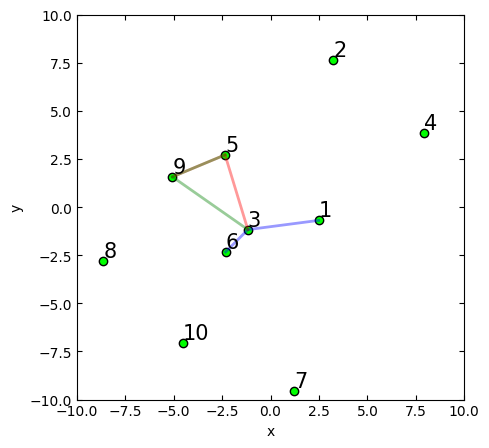

In [ ]:
np.random.seed(42)
r = np.random.randn(10, 2)*5

fig, ax = plt.subplots(figsize=(5, 5))
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(r[:, 0], r[:, 1], c='lime', ec='k')
for i,(x,y) in enumerate(r):
    ax.annotate(str(i),(x,y), size=15, ha='left', va='bottom')

frogs=[2, 4, 8]
color_lis=["b", "r", "g"]
for color, i in enumerate(frogs):

    r_diff=[]
    for j in range(len(r)):
        r_ij=np.linalg.norm(r[i]-r[j])
        r_diff.append(r_ij)

    neighbors = np.argsort(r_diff)[:3]
    neighbors = neighbors[neighbors!=i]

    for k, neighbor in enumerate(neighbors):
        ax.plot([r[i, 0], r[neighbor, 0]], [r[i, 1], r[neighbor, 1]], color=color_lis[color], lw=2, alpha=0.4)

ax.plot()